<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# Plotting and Visualization

At the end of this lesson you will learn:

1. how to use xarray's convenient matplotlib-backed plotting interface to
   visualize your datasets.
2. that `hvplot` provides an equally convenient interface for bokeh-backed plots

## Table of contents

1. [Basic plotting](#basic)
1. [Histograms](#hist)
1. [2D plots](#2d)
1. [1D line plots](#1d)
1. [Faceting or multiple subplots](#facet)
1. [Geography: matplotlib and cartopy](#geo)
1. [Interactive bokeh plots using hvplot](#bokeh)


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
xr.set_options(display_style="html")

## Load data

First lets load up a tutorial dataset to visualize.


In [3]:
ds = xr.tutorial.open_dataset("air_temperature.nc").rename({"air": "Tair"})

# we will add a gradient field with appropriate attributes
ds["dTdx"] = ds.Tair.differentiate("lon") / 110e3 / np.cos(ds.lat * np.pi / 180)
ds["dTdy"] = ds.Tair.differentiate("lat") / 105e3
ds.dTdx.attrs = {"long_name": "$∂T/∂x$", "units": "°C/m"}
ds.dTdy.attrs = {"long_name": "$∂T/∂y$", "units": "°C/m"}

ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    Tair     (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
    dTdx     (time, lat, lon) float32 1.826e-05 1.616e-05 ... -1.882e-06
    dTdy     (time, lat, lon) float32 -9.905e-06 -7.619e-06 ... -1.905e-06
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

This dataset has three "data variables", `Tair` is air temperature and `dTdx`
and `dTdy` are horizontal gradients of this temperature field. All three "data
variables" are three-dimensional with dimensions `(time, lat, lon)`.


<a id='basic'></a>

## Basic plotting: .plot()

DataArray objects have a `plot` method. This method creates plots using
`matplotlib` so all of your existing matplotlib knowledge carries over!

By default `.plot()` makes

1. a line plot for 1-D arrays using `plt.plot()`
2. a `pcolormesh` plot for 2-D arrays using `plt.pcolormesh()`
3. a histogram for everything else using `plt.hist()`


<a id='hist'></a>

## Histograms

`Tair` is three-dimensional, so we got a histogram of temperature values. Notice
the label on the x-axis. One of xarray's convenient plotting features is that it
uses the `attrs` of `Tair` to nicely label axes and colorbars.


(array([   2182.,   60537.,  195026.,  233763.,  315219.,  635948.,
         778807., 1192236.,  453381.,    1901.]),
 array([221.     , 230.64   , 240.28   , 249.92   , 259.56   , 269.2    ,
        278.84   , 288.47998, 298.12   , 307.76   , 317.4    ],
       dtype=float32),
 <BarContainer object of 10 artists>)

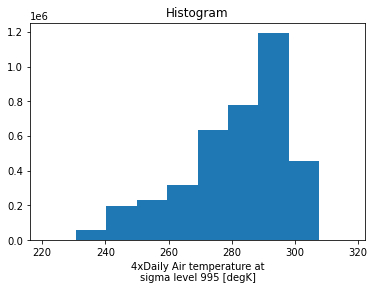

In [4]:
ds.Tair.plot()

You can pass extra arguments to the underlying `hist()` call. See the matplotlib
docs (https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.hist.html) for
all possible keyword arguments.

**Tip:** Note that the returned values are exactly what matplotlib would return

#### Exercise

Update the above plot to show 50 bins with unfilled steps instead of filled
bars.


<a id='2d'></a>

## 2D plots

Now we will explore 2D plots. Let's select a single timestep of `Tair` to
visualize.


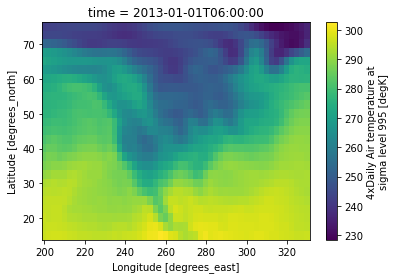

In [5]:
ds.Tair.isel(time=1).plot()

Notice how much information is on that plot!

The x- and y-axes are labeled with full names — "Latitude", "Longitude" — along
with units. The colorbar has a nice label, again with units. And the title tells
us the timestamp of the data presented.

`plot` takes many keyword arguments and is quite sophisticated (see
https://xarray.pydata.org/en/stable/generated/xarray.plot.pcolormesh.html).

Here is a more complicated figure that explicitly sets `time` as the x-axis,
customizes the colorbar, and overlays two contours at specific levels.

**Tip:** Other options for 2D plots include `.plot.contour`, `.plot.contourf`,
`.plot.imshow`


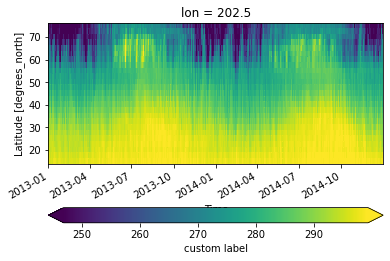

In [6]:
ds.Tair.isel(lon=1).plot(
    x="time",  # coordinate to plot on the x-axis of the plot
    robust=True,  # set colorbar limits to 2nd and 98th percentile of data
    cbar_kwargs={
        "orientation": "horizontal",
        "label": "custom label",
        "pad": 0.2,
    },  # passed to plt.colorbar
)

### Exercise

Update the above plot to use a different matplotlib colormap.


### Exercise

Now overlay a contour plot on top of the previous plot


<a id='1d'></a>

## 1D line plots

xarray is also able to plot lines by wrapping `plt.plot()`. As in the earlier
examples, the axes are labelled and keyword arguments can be passed to the
underlying `matplotlib` call.


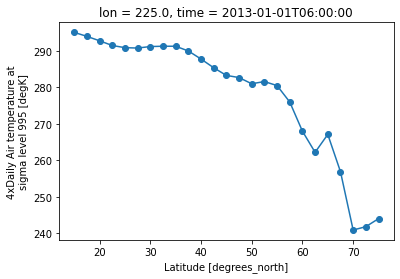

In [7]:
ds.Tair.isel(time=1, lon=10).plot(marker="o")

Lets say we want to compare line plots of temperature at three different
latitudes. We can use the `hue` kwarg to do this.


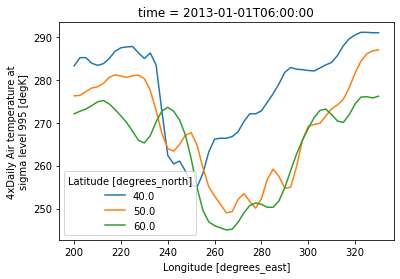

In [8]:
ds.Tair.isel(time=1).sel(lat=[40, 50, 60], method="nearest").plot(
    x="lon", hue="lat"
)

## Customization

All of xarray's plotting functions take an large list kwargs that customize
behaviour. A full list can be seen here:
https://xarray.pydata.org/en/stable/generated/xarray.plot.pcolormesh.html. That
said xarray does not wrap all matplotlib functionality.

The general strategy for making plots that are more complicated that the
examples above is

1. Create a matplotlib axis `ax`
2. Use xarray to make a close approximation of the final plot specifying
   `ax=ax`.
3. Use `ax` methods to fully customize the plot


<a id='facet'></a>

## Faceting

Faceting is the art of presenting "small multiples" of the data. It is an
effective way of visualizing variations of 3D data where 2D slices are
visualized in a panel (subplot) and the third dimensions is varied between
panels (subplots).

Here is where xarray really augments matplotlib's functionality. We will use
monthly means to illustrate


In [9]:
monthly_means = ds.groupby("time.month").mean()
# xarray's groupby reductions drop attributes. Let's assign them back so we get nice labels.
monthly_means.Tair.attrs = ds.Tair.attrs
monthly_means

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, month: 12)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Tair     (month, lat, lon) float32 246.3 246.4 246.2 ... 297.6 297.6 297.5
    dTdx     (month, lat, lon) float32 5.082e-07 -9.469e-07 ... -1.043e-07
    dTdy     (month, lat, lon) float32 -9.553e-06 -9.605e-06 ... -3.872e-06

Note that the dimensions are now `lat, lon, month`.

We want to visualize how the monthly mean air temperature varies with month of
the year.

The simplest way to facet is to specify the `row` or `col` kwargs which are
expected to be a dimension name. Here we use `month` so that each panel or
"facet" of the plot presents the mean temperature field in a given month. Since
a 12 column plot would be too small to interpret, we can "wrap" the facets into
multiple rows using `col_wrap`


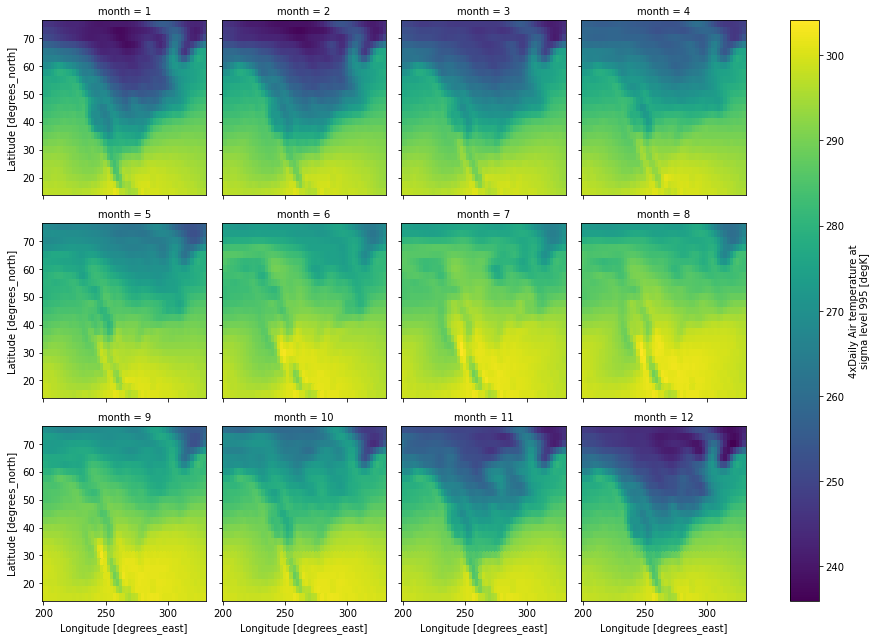

In [10]:
fg = monthly_means.Tair.plot(
    col="month",
    col_wrap=4,  # each row has a maximum of 4 columns
)

All the usual customizations are possible


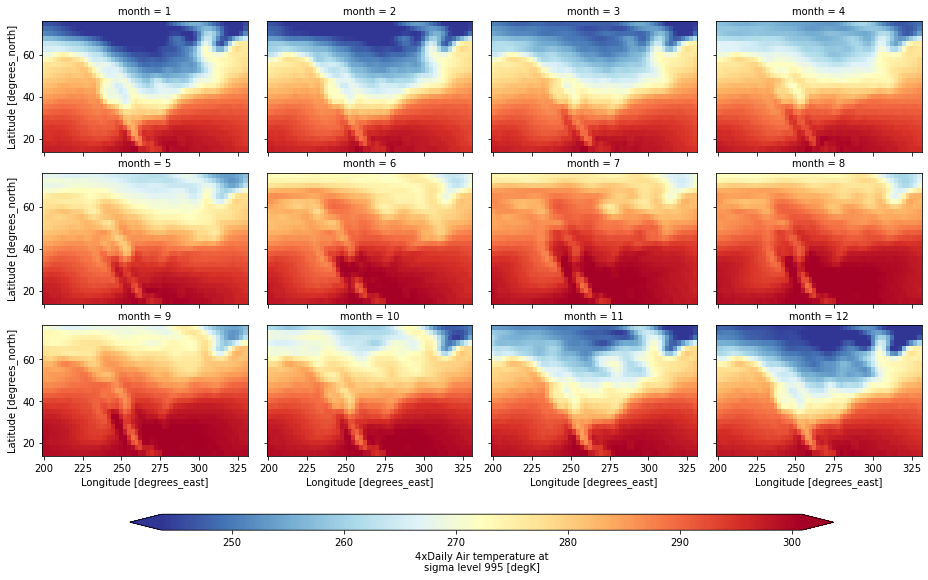

In [11]:
fg = monthly_means.Tair.plot(
    col="month",
    col_wrap=4,
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu_r,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
)

The returned FacetGrid object `fg` has many useful properties and methods e.g.

1. `fg.fig` provides a handle to the figure
2. `fg.axes` is a numpy object array with handles to each individual axes
3. `fg.set_xlabels` and `fg.set_ylabels` can be used to change axes labels.

See https://xarray.pydata.org/en/stable/api.html#faceting for a full list.

### Exercise

Use these methods to set a title for the figure using `suptitle`, as well as
change the x- and y-labels.


In [12]:
fg

### Modifying all facets of a plot

The FacetGrid object has some more advanced methods that let you customize the
plot further.

Here we illustrate the use of `map` and `map_dataarray` that let you map custom
plotting functions to an existing `FacetGrid`. The functions passed to `map` and
`map_dataarray` must have a particular signature. See the docstring for more
details.

Alternatively one can loop over `fg.axes` and modify each individual subplot as
needed


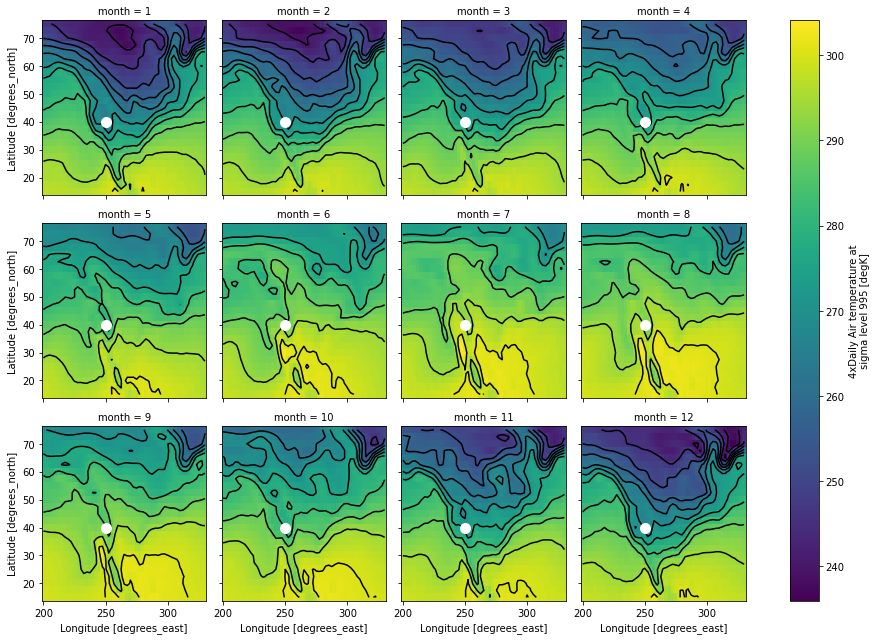

In [13]:
fg = monthly_means.Tair.plot(col="month", col_wrap=4)

# Use this to plot contours on each panel
# Note that this plotting call uses the original DataArray gradients
fg.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)

# Add a point (or anything else!)
fg.map(lambda: plt.plot(250, 40, markersize=20, marker=".", color="w"))

### Faceting tip: Use faceting to plot multiple DataArrays

Faceting can be used to plot multiple DataArrays in a Dataset. The trick is to
use `to_array()` to convert a Dataset to a DataArray and thne facet that.

This trick only works when it is sensible to use the same colormap and color
scale for all DataArrays like with `dTdx` and `dTdy`


In [14]:
gradients = monthly_means[["dTdx", "dTdy"]].to_array("gradient")
gradients

<xarray.DataArray (gradient: 2, month: 12, lat: 25, lon: 53)>
array([[[[ 5.08173684e-07, -9.46942578e-07, -4.03479180e-06, ...,
           1.00858488e-05,  1.81633768e-05,  2.19007525e-05],
         [ 6.02189118e-07, -8.90132014e-07, -4.25928238e-06, ...,
           1.44879168e-05,  3.15986872e-05,  3.92536967e-05],
         [-4.04702814e-06, -4.58570503e-06, -6.01438433e-06, ...,
           2.61500463e-05,  4.34150716e-05,  5.08334851e-05],
         ...,
         [-2.34571348e-06, -1.20601771e-06,  8.53055610e-07, ...,
          -1.45294723e-06, -2.20137940e-06, -2.35507150e-06],
         [-2.84735904e-07, -7.32893909e-07, -6.86845681e-07, ...,
          -1.83361863e-06, -1.57463614e-06, -2.10182111e-06],
         [ 3.16048641e-07, -1.98249467e-07, -4.91980586e-07, ...,
          -1.71716079e-06, -7.17862974e-07, -5.23411643e-07]],

        [[-3.81416953e-06, -5.11973212e-06, -8.09966514e-06, ...,
           1.27637104e-05,  1.81622308e-05,  2.02568535e-05],
         [-4.84793247e-07, -1.95023244e-06, -5.09623078e-06, ...,
           1.05404051e-05,  2.67223077e-05,  3.38635218e-05],
         [-5.29987710e-06, -5.99807481e-06, -7.59168552e-06, ...,
           2.05774650e-05,  3.87745931e-05,  4.66650490e-05],
...
          -1.65317442e-06, -2.42777446e-06, -1.94103222e-06],
         [-1.84547469e-06, -3.26857275e-06, -3.11111307e-06, ...,
          -1.44888838e-06, -2.25341228e-06, -3.15753573e-06],
         [-8.51903962e-07, -1.66222276e-06, -2.48365177e-06, ...,
          -2.15396517e-06, -2.12524083e-06, -3.46904199e-06]],

        [[-6.71428415e-06, -8.14977375e-06, -9.80123150e-06, ...,
           3.74177898e-06,  2.25041845e-07, -5.66836025e-06],
         [-7.73049214e-06, -6.68594612e-06, -6.57780447e-06, ...,
           3.23118388e-06, -1.69362568e-06, -8.46021612e-06],
         [-1.21043013e-05, -1.01668966e-05, -9.37458026e-06, ...,
          -2.60197321e-05, -3.02746539e-05, -3.18970924e-05],
         ...,
         [-1.97388658e-06, -2.87304010e-06, -2.76804826e-06, ...,
          -2.31021318e-06, -2.91697165e-06, -2.45591286e-06],
         [-2.12526766e-06, -3.82872440e-06, -3.59293290e-06, ...,
          -2.17964885e-06, -2.80768063e-06, -3.58095190e-06],
         [-1.57234820e-06, -2.31013792e-06, -2.78555922e-06, ...,
          -2.83686700e-06, -2.73794444e-06, -3.87158479e-06]]]],
      dtype=float32)
Coordinates:
  * lat       (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon       (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * gradient  (gradient) <U4 'dTdx' 'dTdy'

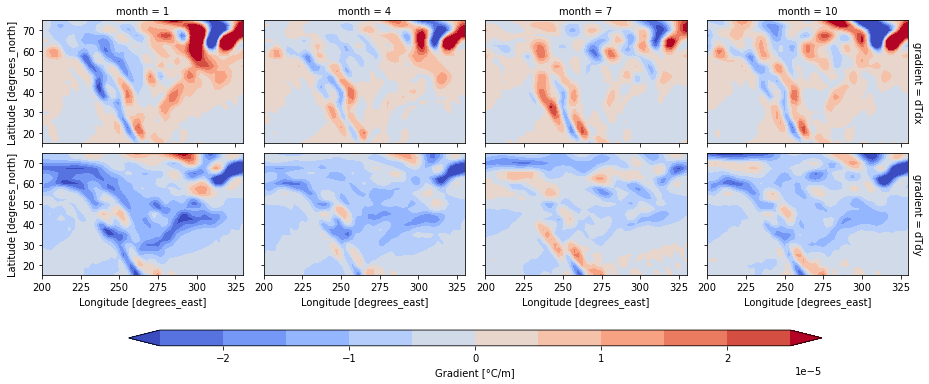

In [15]:
fg = gradients.isel(month=slice(None, None, 3)).plot.contourf(
    levels=13,
    col="month",
    row="gradient",
    robust=True,
    cmap=mpl.cm.coolwarm,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "label": "Gradient [°C/m]",
    },
)

<a id="geo"></a>

## Geography: Matplotlib and Cartopy

Since xarray's default plotting functionality builds on matplotlib, we can
seamlessly use cartopy to make nice maps:

1. Specify a `projection` for the plot when creating a new figure `fig` with
   axis `axis`.
2. Explicitly ask xarray to plot to axis `axis` by passing the kwarg `ax=axis`.
3. Specify the projection of the data using `transform` (`PlateCarree` here) in
   `.plot()`.


/home/travis/miniconda/envs/xarray/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


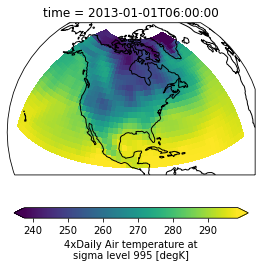

In [16]:
import cartopy.crs as ccrs

fig, axis = plt.subplots(
    1, 1, subplot_kw=dict(projection=ccrs.Orthographic(-90, 30))
)

ds.Tair.isel(time=1).plot(
    ax=axis,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
    robust=True,
)
axis.coastlines()  # cartopy function

### Faceting maps

We can make faceted maps. Since `FacetGrid` creates the axes it plots to, we
need to pass the `projection` kwarg in `subplot_kws`. This makes sure that the
subplots are set up properly for cartopy.


/home/travis/miniconda/envs/xarray/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


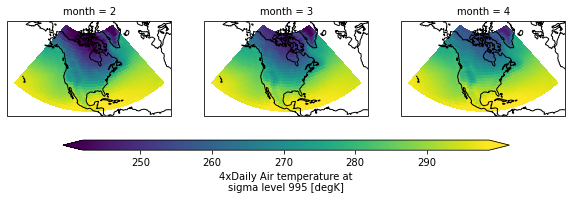

In [17]:
fg = monthly_means.Tair.isel(month=[1, 2, 3]).plot(
    col="month",
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={
        "projection": ccrs.LambertConformal(
            central_longitude=-95, central_latitude=45
        )
    },
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
    robust=True,
)

# lets add a coastline to each axis
# great reason to use FacetGrid.map
fg.map(lambda: plt.gca().coastlines())

<a id="bokeh"></a>

## Interactive bokeh plots using hvplot

Xarray's builtin plotting functionality wraps matplotlib.

The `holoviews` plotting ecosystem provides the `hvplot` package to allow easy
visualization of xarray (and other) objects (https://hvplot.holoviz.org/). These
plots build on [Bokeh](https://bokeh.org/).

`hvplot` makes uses of xarray's accessor interface. This means that all xarray
objects gain a `.hvplot` attribute that lets you access `hvplot` functionality
as easily as you would use `.plot`


In [18]:
import hvplot.xarray

**`hvplot` makes the same default choices as xarray**


In [19]:
ds.Tair.hvplot()

:NdOverlay   [Element]
   :Histogram   [Tair]   (Tair_count)

In [20]:
# 2D array yields a quadmesh plot
ds.Tair.isel(time=1).hvplot(cmap="fire")

:Image   [lon,lat]   (Tair)

In [21]:
# 1D array yields a line plot
ds.Tair.isel(time=1, lon=1).hvplot()

:Curve   [lat]   (Tair)

### Interactivity

But `hvplot` shines when interactivity is used. Here we can give it _all_ the
data and ask it to create a nice slider to control the time slice using the
`groupby` kwarg.


In [22]:
ds.Tair.hvplot(
    groupby="time",
    clim=(250, 295),  # adds a widget for time  # sets colorbar limits
)

:DynamicMap   [time]
   :Image   [lon,lat]   (Tair)

Animations are easy


In [23]:
# set constant colorbar limits
ds.Tair.hvplot(
    groupby="time",  # adds a widget for time
    clim=(250, 295),  # sets colormap limits
    widget_type="scrubber",
    widget_location="bottom",
)

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=2919, width=550)
        [2] HSpacer()

### Geography


In [24]:
ds.Tair.isel(time=1).hvplot(
    projection=ccrs.Orthographic(-90, 30),
    coastline=True,
)

:Overlay
   .Image.I     :Image   [lon,lat]   (Tair)
   .Coastline.I :Feature   [Longitude,Latitude]

## More resources

1. Xarray's visualization gallery:
   https://xarray.pydata.org/en/stable/examples/visualization_gallery.html
2. Xarray's plotting documentation:
   https://xarray.pydata.org/en/stable/plotting.html
3. hvplot's plotting documentation:
   https://hvplot.holoviz.org/user_guide/Gridded_Data.html
